# 数据分析流水线

## 读一条数据

这里以 afdb 中的 `04015` 这一条数据为例 (注: 有些数据，例如 `00735` 是没有 `.dat` 的), 在下载了文件之后，目前项目结构是这样的:

```
data/
    afdb/
        04015.atr
        04015.dat
        04015.qrs
        04015.hea
docs/
    source/
        pipeline.ipynb (本文件)
```

那么 afdb 的目录相对于本文件就是： `../../data/afdb/`。`04015` 这一条数据的完整的名字就是 `../../data/afdb/04015`。


In [1]:
import wfdb

afdb_dir = '../..//data/afdb/'
record_name = '04015'
record_name = f"{afdb_dir}{record_name}"

full_record = wfdb.rdrecord(record_name)

print('record =', full_record)
print('details =', full_record.__dict__)

record = <wfdb.io.record.Record object at 0x000001D592B6D390>
details = {'record_name': '04015', 'n_sig': 2, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 9205760, 'base_time': datetime.time(9, 0), 'base_date': None, 'comments': [], 'sig_name': ['ECG1', 'ECG2'], 'p_signal': array([[-0.275, -0.21 ],
       [-0.295, -0.2  ],
       [-0.31 , -0.22 ],
       ...,
       [-0.68 , -1.345],
       [-0.67 , -1.23 ],
       [-0.665, -1.165]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['04015.dat', '04015.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [-55, -42], 'checksum': [-27172, -28460], 'block_size': [0, 0]}


在 wfdb 的 Record 结构中，有这个关键的信息:

- `n_sig = 2` 表明有两个 channel
- `fs = 250` 表明采样率是 250 Hz
- `sig_len = 9205760` 表明数据长度是 9205760
- `sig_name = ['ECG1', 'ECG2']` 是两个 channel 分别的名字
- `p_signal = array()` 是两个 channel 的数据的数组。

还要注意，在 `rdrecord()` 时的默认参数是 `physical=True`，因此读出来以后自动做了 DAC 处理，因此是 `p_signal`。如果读的时候指定 `physical=False` 那么就要使用 `d_signal` 。

下面我们绘制一下看看：

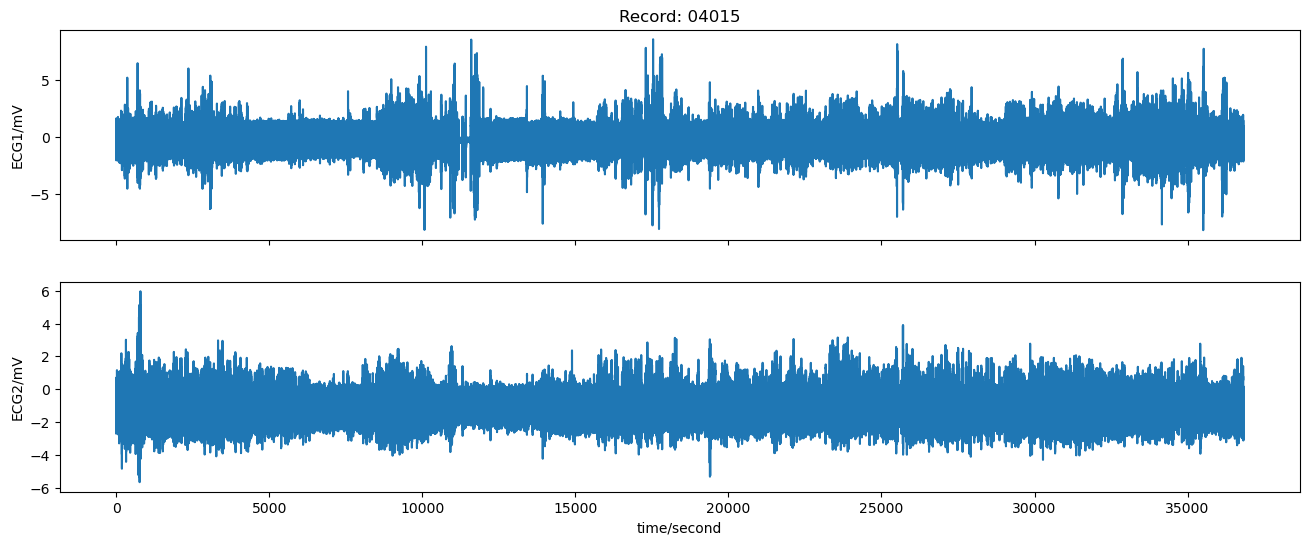

In [2]:
wfdb.plot_wfdb(full_record, figsize=(16, 6))

## 读局部的数据

刚才这样读出来太长了，没办法看到细节。为了观察其中的一小段，我们在读取的时候使用 `sampfrom` 和 `sampto` 参数，指定这个范围重新读一次看看：

（注：这里的具体数值是结合后面 atr 的标注选择的，在这一段中恰好有一部分房颤和一部分正常，且长度还算合适）

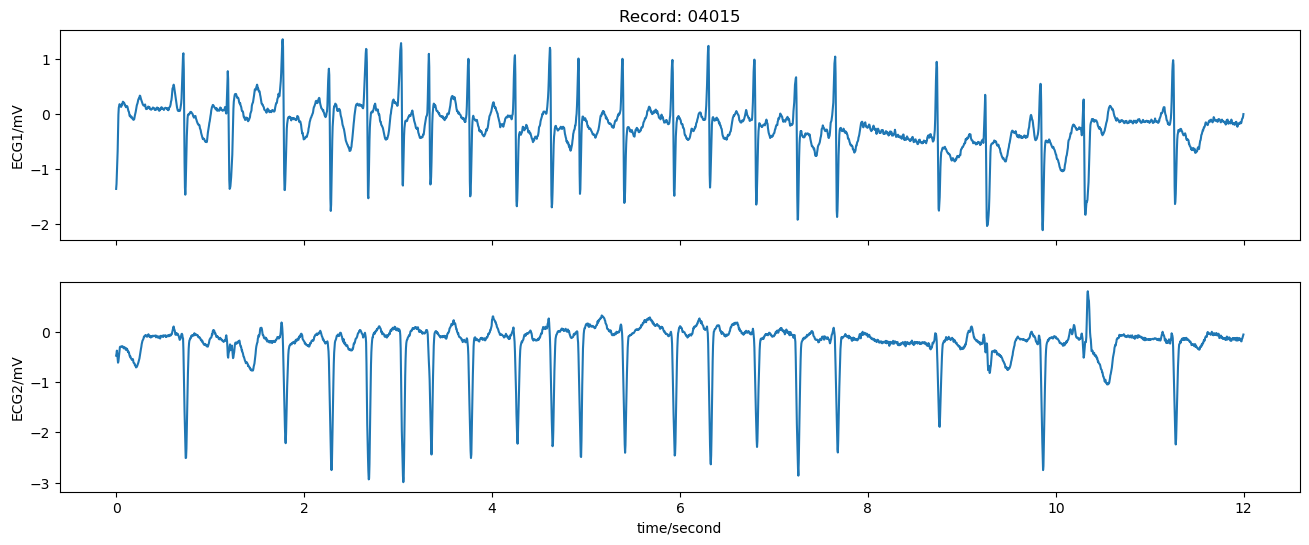

In [3]:
sampfrom = 1096000
sampto = 1099000

record = wfdb.rdrecord(record_name, sampfrom=sampfrom, sampto=sampto)
wfdb.plot_wfdb(record, figsize=(16, 6))

我们在这个片段中拿 `ECG1` 来看看:

注意直接读出来的 `p_signal` 是 `(2, 2500)`, 将其转置后取第一维：

In [4]:
signal = record.p_signal.T[0]

print('ECG1 =', signal, ', shape =', signal.shape)

ECG1 = [-1.37  -1.28  -1.085 ... -0.085 -0.06  -0.01 ] , shape = (3000,)


## 读标注信息

afdb 的标注信息分为如下几个：

- `.atr` 文件标注了节律，如 `(AFIB`, `(AFL`, `(N` 等
- `.qrs` 和 `.qrsc` 文件标注了心拍

In [5]:
ann = wfdb.rdann(record_name, "atr", sampfrom=sampfrom, sampto=sampto)

print("ann =", ann)
print("details =", ann.__dict__)


ann = <wfdb.io.annotation.Annotation object at 0x000001D597DFEE30>
details = {'record_name': '04015', 'extension': 'atr', 'sample': array([1096245, 1098054], dtype=int64), 'symbol': ['+', '+'], 'subtype': array([0, 0]), 'chan': array([0, 0]), 'num': array([0, 0]), 'aux_note': ['(AFIB', '(N'], 'fs': 250, 'label_store': None, 'description': None, 'custom_labels': None, 'contained_labels': None, 'ann_len': 2}


`ann` 中的信息:

- `ann_len` = `2` 是这一段中包含的总标注的数量
- `sample` = `[1096245, 1098054]` 是每个标注的位置
- `symbol` = `['+', '+']` 是每个标注的符号 (在 afdb 项目中不用它)
- `chan` = `[0, 0]` 是每个标注所对应的通道号 (在 afdb 项目中不用它)
- `aux_note` = `['(AFIB', '(N']` 是每个标注的备注信息 (在 afdb 项目中是重要的)
- `fs` = `250` 是采样率

注意, 此处 ann 的位置是从 `0` 而非从 `sampfrom` 开始计数的，而 record 中的 signal 是从读取时指定的 `sampfrom` 开始计数的 (范围已经变成了 `[0, 2999]`)，因此要正确绘制的话，还要把 ann 的位置平移回去。

将其绘制出来就是这样的：

In [6]:
# 将 ann 平移
ann.sample -= sampfrom

# 为了能直接在图中画出来，手动再设置一下 ann 的 label
ann.symbol = ann.aux_note

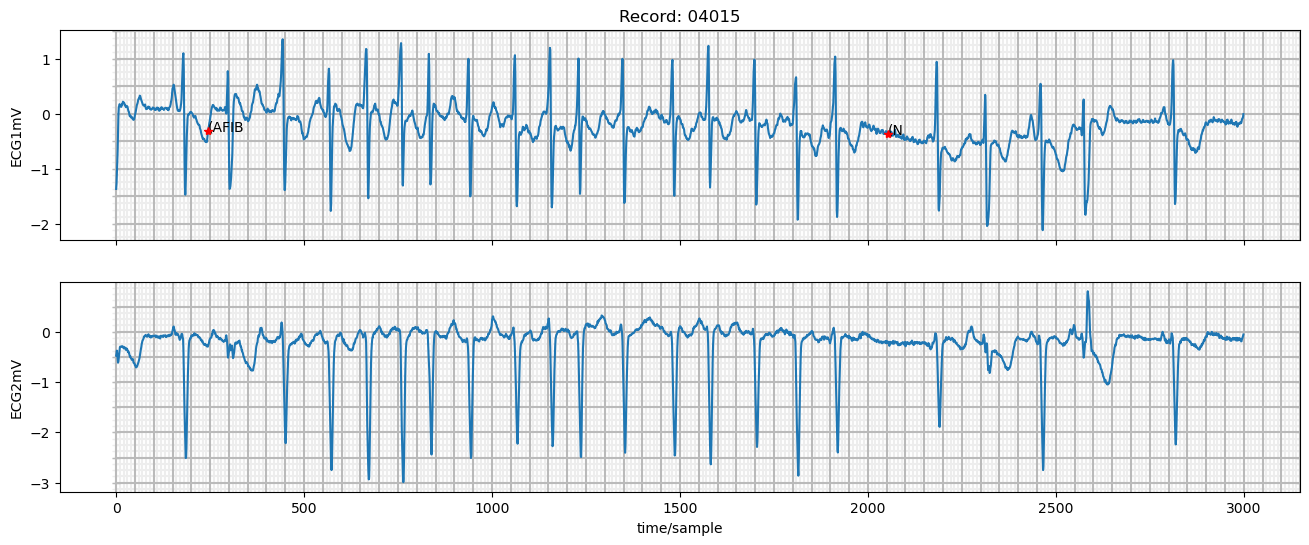

In [7]:
wfdb.plot_wfdb(record, ann, plot_sym=True, time_units='samples', ecg_grids='all', figsize=(16, 6))

## 数据预处理

所以现在我们拿到了 `signal`，下面做一些简单的预处理

In [8]:
signal

array([-1.37 , -1.28 , -1.085, ..., -0.085, -0.06 , -0.01 ])

这里随便写了一个 butterworth 滤波器，以 sos 形式应用到 filtfilt 方法中。

In [9]:
from scipy.signal import sosfiltfilt, butter

filter = butter(3, [5, 20], btype='bandpass', output='sos', fs=record.fs)
signal_filtered = sosfiltfilt(filter, signal)

我们画一下看看：

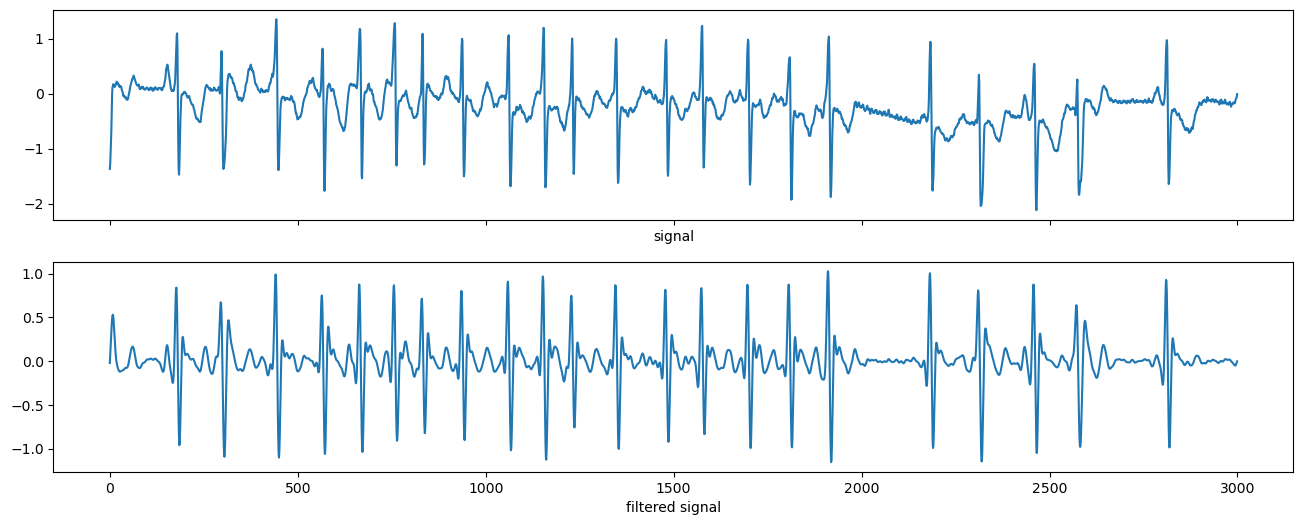

In [10]:
from matplotlib import pyplot

pyplot.subplots(2, 1, sharex='all', figsize=(16, 6))
pyplot.subplot(2, 1, 1)
pyplot.xlabel('signal')
pyplot.plot(signal)
pyplot.subplot(2, 1, 2)
pyplot.xlabel('filtered signal')
pyplot.plot(signal_filtered)

## 特征提取

现在我们有了 `signal` 和 `filtered_signal` 。那么接下来看看特征提取的环节。

### QRS 提取

仅关心位置的 QRS 提取器可以抽象为 `function(signal: array): List[int]`

这里使用一个简单的分析器来实现：

In [11]:
from wfdb.processing import XQRS
import numpy

def xqrs_detector(signal: numpy.ndarray) -> numpy.ndarray:
    xqrs = XQRS(signal, fs=record.fs)
    xqrs.detect()
    return xqrs.qrs_inds

qrs_location = xqrs_detector(signal)

print('detected QRS at', qrs_location)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
detected QRS at [ 185  305  450  572  672  756  838  944 1067 1161 1236 1354 1486 1573
 1705 1815 1919 2182 2319 2466 2582 2819]


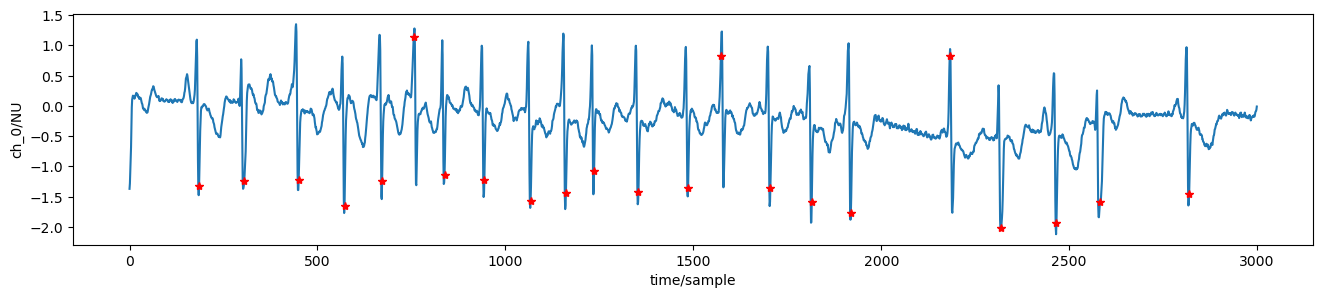

In [12]:
wfdb.plot_items(signal, ann_samp=[qrs_location], figsize=(16, 3))

### RR-I 计算

In [13]:
rri = numpy.diff(qrs_location)

print('R-R interval in samples', rri)

rri_ms = rri / record.fs * 1000

print('R-R interval in ms:', rri_ms)

R-R interval in samples [120 145 122 100  84  82 106 123  94  75 118 132  87 132 110 104 263 137
 147 116 237]
R-R interval in ms: [ 480.  580.  488.  400.  336.  328.  424.  492.  376.  300.  472.  528.
  348.  528.  440.  416. 1052.  548.  588.  464.  948.]


Text(0.5, 1.0, 'R-R interval in ms')

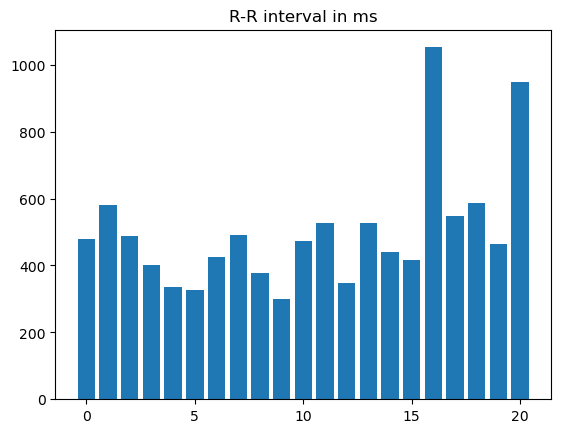

In [14]:
pyplot.bar(range(len(rri_ms)), rri_ms)
pyplot.title("R-R interval in ms")